# Optimisation of a Neocortical Layer 5 Pyramidal Cell

This notebook shows you how to optimise the maximal conductance of Neocortical Layer 5 Pyramidal Cell as used in Markram et al. 2015.

Author of this script: Werner Van Geit @ Blue Brain Project

Choice of parameters, protocols and other settings was done by Etay Hay @ HUJI

What's described here is a more advanced use of BluePyOpt. We suggest to first go through the introductary example here: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/simplecell/simplecell.ipynb

**If you use the methods in this notebook, we ask you to cite the following publications when publishing your research:**

Van Geit, W., M. Gevaert, G. Chindemi, C. Rössert, J.-D. Courcol, E. Muller, F. Schürmann, I. Segev, and H. Markram (2016, March). BluePyOpt: Leveraging open source software and cloud infrastructure to optimise model parameters in neuroscience. ArXiv e-prints.
http://arxiv.org/abs/1603.00500

Markram, H., E. Muller, S. Ramaswamy, M. W. Reimann, M. Abdellah, C. A. Sanchez, A. Ailamaki, L. Alonso-Nanclares, N. Antille, S. Arsever, et al. (2015). Reconstruction and simulation of neocortical microcircuitry. Cell 163(2), 456–492.
http://www.cell.com/abstract/S0092-8674%2815%2901191-5

Some of the modules loaded in this script are located in the L5PC example folder: https://github.com/BlueBrain/BluePyOpt/tree/master/examples/l5pc 

We first load the bluepyopt python module, the ephys submodule and some helper functionality

In [1]:
from __future__ import print_function
from numba import jit
import numpy as np
@jit
def linearInterpolate(tStart, tEnd, vStart, vEnd, tTarget):
    """Perform linear interpolation."""
    tRange = float(tEnd - tStart)
    tFractionAlong = (tTarget - tStart)/tRange
    vRange = vEnd - vStart
    vTarget = vRange*tFractionAlong + vStart
    return vTarget

@jit
def inner_core(fPots,vIndex,vTime,fTime,duration,vTimes,vPots,fDt):
    while fTime <= duration:
    #for fTime in iterator:
        # If v and f times are exact, no interpolation needed
        if fTime == vTime:
            fPots.append(vPots[vIndex])

        # Interpolate between the two nearest vdt times
        else:

            # Increment vdt time until it surpases the fdt time
            while fTime > vTime and vIndex < len(vTimes):
                vIndex += 1
                vTime = vTimes[vIndex]

            # Once surpassed, use the new vdt time and t-1
            # for interpolation
            vIndexMinus1 = max(0, vIndex-1)
            vTimeMinus1 = vTimes[vIndexMinus1]
            
            #def linearInterpolate(tStart, tEnd, vStart, vEnd, tTarget):
            tStart, tEnd, vStart, vEnd, tTarget = vTimeMinus1, vTime,vPots[vIndexMinus1],vPots[vIndex], fTime
            tRange = float(tEnd - tStart)
            tFractionAlong = (tTarget - tStart)/tRange
            vRange = vEnd - vStart
            fPot = vRange*tFractionAlong + vStart

            
            #fPot = linearInterpolate(vTimeMinus1, vTime,
            #                              vPots[vIndexMinus1],
            #                              vPots[vIndex], fTime)

            fPots.append(fPot)
            
        # Go to the next fdt time step
        fTime += fDt
    return fPots


@jit
def get_variable_step_analog_signal(desired_fixedTimeStep,varied_Pots,varied_Times):#,iterator):
    """Convert variable dt array values to fixed dt array.

    Uses linear interpolation.
    """
    # Fixed dt potential
    fPots = []
    fDt = desired_fixedTimeStep
    # Variable dt potential
    vPots = varied_Pots
    #self.vVector.to_python()
    # Variable dt times
    vTimes = varied_Times#self.tVector.to_python()
    duration = vTimes[len(vTimes)-1]
    # Fixed and Variable dt times
    fTime = vTimes[0]
    vTime = vTimes[0]
    # Index of variable dt time array
    vIndex = 0
    # Advance the fixed dt position
    #
    
    fPots = inner_core(fPots,int(vIndex),float(vTime),float(fTime),float(duration),list(vTimes),list(vPots),float(fDt))
    return fPots


/home/user/anaconda3/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)


<IPython.core.display.Javascript object>


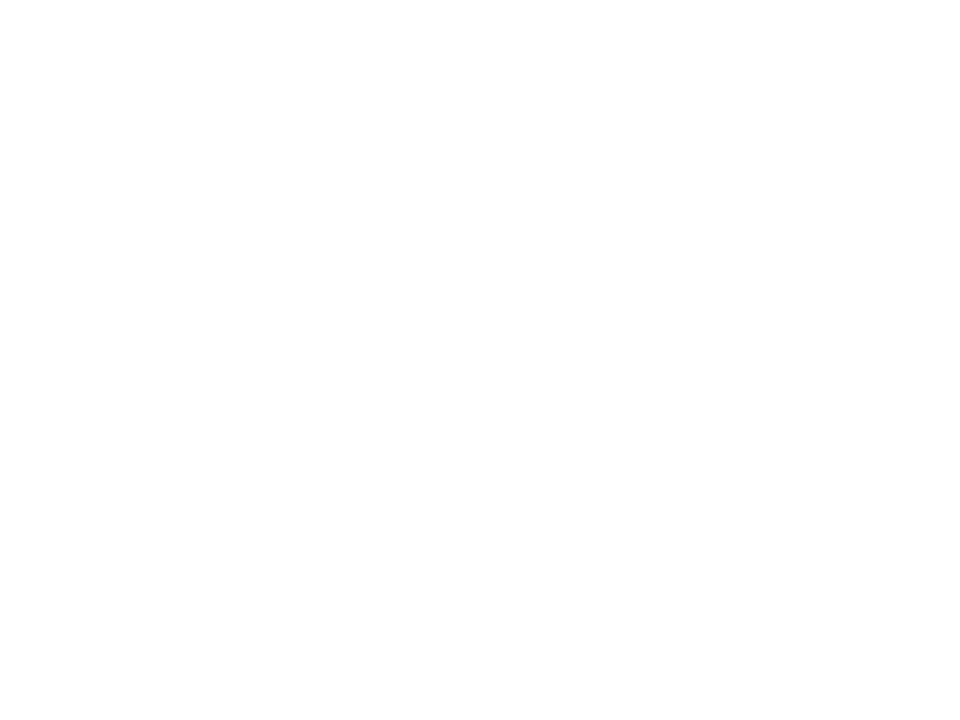

In [2]:
%load_ext autoreload
%autoreload
if False:
    !nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot([1,0],[0,1])
plt.show()

Enable the code below to enable debug level logging

In [3]:
# import logging                                                                      
# logging.basicConfig()                                                               
# logger = logging.getLogger()                                                        
# logger.setLevel(logging.DEBUG)   

## Model description

### Morphology

We're using a complex reconstructed morphology of an L5PC cell. Let's visualise this with the BlueBrain NeuroM software:

In [4]:
if False:
    try:
        import neurom.viewer
        neurom.viewer.draw(neurom.load_neuron('morphology/C060114A7.asc'));
    except:
        !pip install neurom --upgrade
        import neurom.viewer
        neurom.viewer.draw(neurom.load_neuron('morphology/C060114A7.asc'));

To load the morphology we create a NrnFileMorphology object. We set 'do_replace_axon' to True to replace the axon with a AIS.

In [5]:
morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
print(str(morphology))

morphology/C060114A7.asc


### Parameters

Since we have many parameters in this model, they are stored in a json file: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/l5pc/config/parameters.json

In [6]:
import json
param_configs = json.load(open('config/parameters.json'))
print([param_config['param_name'] for param_config in param_configs])

['g_pas', 'e_pas', 'cm', 'Ra', 'v_init', 'celsius', 'ena', 'ek', 'cm', 'ena', 'ek', 'cm', 'ena', 'ek', 'gIhbar_Ih', 'gNaTs2_tbar_NaTs2_t', 'gSKv3_1bar_SKv3_1', 'gImbar_Im', 'gIhbar_Ih', 'gNaTa_tbar_NaTa_t', 'gNap_Et2bar_Nap_Et2', 'gK_Pstbar_K_Pst', 'gK_Tstbar_K_Tst', 'gSK_E2bar_SK_E2', 'gSKv3_1bar_SKv3_1', 'gCa_HVAbar_Ca_HVA', 'gCa_LVAstbar_Ca_LVAst', 'gamma_CaDynamics_E2', 'decay_CaDynamics_E2', 'gNaTs2_tbar_NaTs2_t', 'gSKv3_1bar_SKv3_1', 'gSK_E2bar_SK_E2', 'gCa_HVAbar_Ca_HVA', 'gCa_LVAstbar_Ca_LVAst', 'gamma_CaDynamics_E2', 'decay_CaDynamics_E2', 'gIhbar_Ih']


The directory that contains this notebook has a module that will load all the parameters in BluePyOpt Parameter objects

In [7]:
import l5pc_model
parameters = l5pc_model.define_parameters()
[(p.lower_bound,p.upper_bound) for p in parameters];
pass

In [8]:
#parameters = l5pc_model.define_parameters()


In [9]:
#import pdb
#pdb.set_trace()

As you can see there are two types of parameters, parameters with a fixed value and parameters with bounds. The latter will be optimised by the algorithm.

### Mechanism

We also need to add all the necessary mechanisms, like ion channels to the model. 
The configuration of the mechanisms is also stored in a json file, and can be loaded in a similar way.

In [10]:
mechanisms = l5pc_model.define_mechanisms()
#print('\n'.join('%s' % mech for mech in mechanisms))

# Cell model

With the morphology, mechanisms and parameters we can build the cell model

In [11]:
l5pc_cell = ephys.models.CellModel('l5pc', morph=morphology, mechs=mechanisms, params=parameters)
#print(l5pc_cell)

For use in the cell evaluator later, we need to make a list of the name of the parameters we are going to optimise.
These are the parameters that are not frozen.

In [12]:
param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      

## Protocols

Now that we have a cell model, we can apply protocols to it. The protocols are also stored in a json file.

In [13]:
proto_configs = json.load(open('config/protocols.json'))
#print(proto_configs)

And they can be automatically loaded

In [14]:
import l5pc_evaluator
fitness_protocols = l5pc_evaluator.define_protocols()
#print('\n'.join('%s' % protocol for protocol in fitness_protocols.values()))


feature_configs = json.load(open('config/features.json'))
#pp.pprint(feature_configs)

#feature_configs.pop('bAP',None);
#fitness_protocols.pop('bAP',None);

10/1000

0.01

In [15]:
import quantities as pq

for k,v in fitness_protocols.items():
    for i in fitness_protocols[k].stimuli:
        params = {'amplitude':0,'duration':1000*pq.ms,'delay':100*pq.ms}


        if k==str('Step1'):
            params = {'amplitude':0,'duration':1000*pq.ms,'delay':100*pq.ms}

            i.total_duration = float(params['delay'])+float(params['duration'])
            i.step_delay = float(params['delay'])
            i.step_duration = float(params['duration'])

            i.step_amplitude = 0.090000 # nano to pico
        elif k==str('Step2'):            
            PASSIVE_DURATION = 500.0*pq.ms
            PASSIVE_DELAY = 200.0*pq.ms
            params = {'amplitude':0,'duration':PASSIVE_DURATION,'delay':PASSIVE_DELAY}
            i.step_delay = float(params['delay'])
            i.step_duration = float(params['duration'])

            i.step_amplitude = -0.01 # nano to pico
        

In [16]:
#fitness_protocols.pop('bAP',None)

In [17]:
fitness_protocols['Step1'].stimuli[0].total_duration



1100.0

In [18]:
#fitness_protocols['Step1'].stimuli.total_duration = 

## eFeatures

For every protocol we need to define which eFeatures will be used as objectives of the optimisation algorithm.

Hijack protocols by editing config dictionaries.

Make static models from waveform only

In [19]:
feature_configs;

In [20]:
fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols)


## Simulator

We need to define which simulator we will use. In this case it will be Neuron, i.e. the NrnSimulator class

In [21]:
sim = ephys.simulators.NrnSimulator()

## Evaluator

With all the components defined above we can build a cell evaluator

In [22]:
evaluator = ephys.evaluators.CellEvaluator(                                          
        cell_model=l5pc_cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)  

This evaluator can be used to run the protocols. The original parameter values for the Markram et al. 2015 L5PC model are:

In [23]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}


In [24]:
temp = list(fitness_protocols.values())


Running the responses is as easy as passing the protocols and parameters to the evaluator. (The line below will take some time to execute)

In [25]:
release_responses = evaluator.run_protocols(protocols=[temp[-1],temp[-2]], param_values=release_params)

In [26]:

release_responses.keys()
release_responses.pop('neo_Step1.soma.v',None)

AnalogSignal with 1 channels of length 1131; units mV; datatype float64 
sampling rate: 734.3019924337643 1/ms
time: 0.0 s to 0.0015402382284861072 s

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


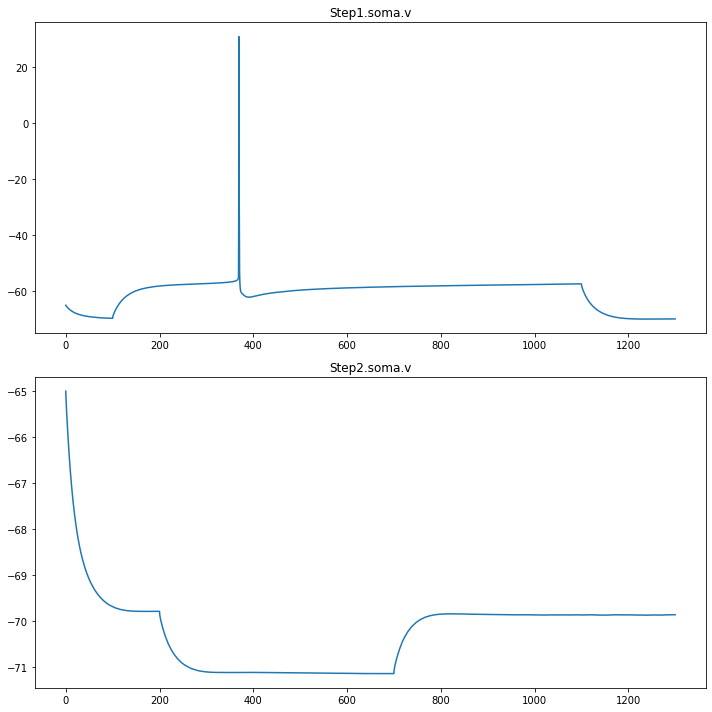

In [27]:

def plot_responses(responses):
    fig, axes = plt.subplots(2, figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(responses.items())):
        axes[index].plot(response['time'], response['voltage'], label=resp_name)
        axes[index].set_title(resp_name)
    fig.tight_layout()
    fig.show()

plot_responses(release_responses)

In [28]:
import pickle
from neo import AnalogSignal
from neuronunit.models import StaticModel



tests = pickle.load(open("processed_multicellular_constraints.p","rb"))
l5pc_tests = tests['Neocortex pyramidal cell layer 5-6'].tests

def score_model(release_responses_l,l5pc_tests,rheobase):
    response = release_responses_l.get('Step1.soma.v')

    temp_iter = list(np.arange(0,response['time'][len(response['time'])-1],response['time'][1]))
    #print(temp_iter)
    rectified = get_variable_step_analog_signal(response['time'][1],response['voltage'],response['time'])#,temp_iter)


    active_vM = AnalogSignal(rectified,
                                    units=pq.mV,
                                    sampling_period=response['time'][1]*pq.ms)
    plt.clf()
    plt.plot(active_vM.times, active_vM)#, label=resp_name)


    response = release_responses_l.get('Step2.soma.v')
    temp_iter = list(np.arange(0,response['time'][len(response['time'])-1],response['time'][1]))

    rectified = get_variable_step_analog_signal(response['time'][1],response['voltage'],response['time'])#,temp_iter)
    passive_vM = AnalogSignal(rectified,
                                    units=pq.mV,
                                    sampling_period=response['time'][1]*pq.ms)
    plt.clf()
    plt.plot(passive_vM.times, passive_vM)#, label=resp_name)
    

    sm_active = StaticModel(vm=active_vM)
    sm_active.vM = active_vM
    sm_active.run_params = None
    sm_active.run_params = {}

    sm_passive = StaticModel(vm=passive_vM)
    sm_passive.vM = passive_vM

    sm_passive.run_params = None
    sm_passive.run_params = {}
    scores_active = {}
    from sciunit.scores import ZScore
    for t in l5pc_tests:
        t.score_type = ZScore
    for t in l5pc_tests[5::]:

        score = t.judge(sm_active)
        print(t.name,t.observation,t.prediction)
        scores_active[t.name] = score

    scores_passive = {}
    for t in l5pc_tests[1:5]:    
        score = t.judge(sm_passive)
        print(t.name,t.observation,t.prediction)

        scores_passive[t.name] = score
    #scores_all = scores_active
    #scores_all.extend(scores_passive)
    
    
    l5pc_tests[0].prediction = {'value':rheobase*pq.pA}
    l5pc_tests[0].score_type = ZScore
    rh_score = l5pc_tests[0].compute_score(l5pc_tests[0].observation,l5pc_tests[0].prediction)
    #print(l5pc_tests[0].observation,l5pc_tests[0].prediction)
    #rh_score

    scores = []
    scores.append(rh_score)
    scores.extend(list(scores_passive.values()))
    scores.extend(list(scores_active.values()))
    
    #l5pc_tests[0].prediction = {'value':0.090000 *1000.0*pq.pA}
    #l5pc_tests[0].score_type = ZScore
    #rh_score = l5pc_tests[0].compute_score(l5pc_tests[0].observation,l5pc_tests[0].prediction)
    #print(l5pc_tests[0].observation,l5pc_tests[0].prediction)
    #rh_score
    #scores_all.append(rh_score)
    
    #plt.clf()
    
    fig, axes = plt.subplots(3, figsize=(10,10))
   
    axes[0].plot(active_vM.times, active_vM, label='supra threshold injection')
    axes[0].plot(passive_vM.times, passive_vM, label='sub threshold injection')
    fig.tight_layout()
    fig.show()
    return scores


#axes.set_title(resp_name)
#plt.show()
#plt.savefig('interpolated.png')

{'amplitude': array(0.) * pA, 'delay': array(100.) * ms, 'duration': array(300.) * ms, 'dt': array(0.025) * ms, 'padding': array(200.) * ms}


<ipython-input-1-d35edc268558>:53: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_variable_step_analog_signal" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-1-d35edc268558> (60)

File "<ipython-input-1-d35edc268558>", line 60:
def get_variable_step_analog_signal(desired_fixedTimeStep,varied_Pots,varied_Times):#,iterator):
    <source elided>
    # Fixed dt potential
    fPots = []
    ^

  @jit
/home/user/anaconda3/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "get_variable_step_analog_signal" was compiled in object mode without forceobj=True.

File "<ipython-input-1-d35edc268558>", line 54:
@jit
def get_variable_step_analog_signal(desired_fixedTimeStep,varied_Pots,varied_Times):#,iterator):
^

  self.func_ir.loc))
/home/user/anaconda3/lib/python3.7/site-packages/numba/compiler.py:751: NumbaDeprecationWarning: 
Fall-back from the nopython comp

InjectedCurrentAPWidthTest {'mean': array(1.20769388) * ms, 'std': array(0.53434592) * ms, 'n': 49} {'mean': array(5.99208506e-05) * s, 'std': array(0.) * s, 'n': 1}
InjectedCurrentAPAmplitudeTest {'mean': array(80.43510204) * mV, 'std': array(12.74880304) * mV, 'n': 49} {'value': array(81.76377401) * mV, 'mean': array(81.76377401) * mV, 'std': array(0.) * mV, 'n': 1}
InjectedCurrentAPThresholdTest {'mean': array(-42.73572327) * mV, 'std': array(8.04073233) * mV, 'n': 53} {'mean': array(-50.87516107) * mV, 'std': array(0.) * mV, 'n': 1}
InputResistanceTest {'mean': array(120.67207364) * Mohm, 'std': array(77.63316083) * Mohm, 'n': 86} {'value': array(1.46155997e+08) * kg*m**2/(s**3*A**2)}
TimeConstantTest {'mean': array(15.73424242) * ms, 'std': array(7.31162637) * ms, 'n': 33} {'value': array(0.00085249) * ms}
CapacitanceTest {'mean': array(150.58416667) * pF, 'std': array(139.68388463) * pF, 'n': 12} {'value': array(5.83273916e-15) * s**4*A**2/(kg*m**2)}
RestingPotentialTest {'mean':

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


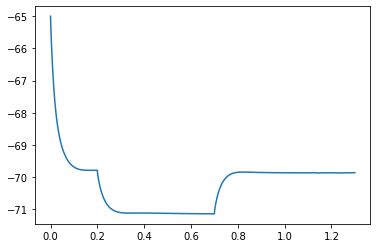

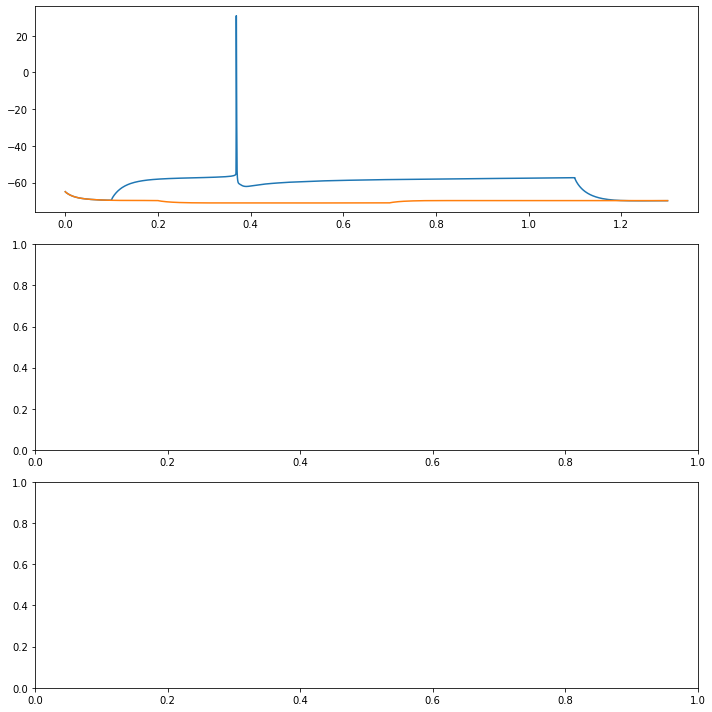

In [29]:
scores = score_model(release_responses,l5pc_tests,0.090000)

In [30]:
scores

[Z = -1.25,
 Z = 0.33,
 Z = -2.15,
 Z = -1.08,
 Z = -0.25,
 Z = -2.15,
 Z = 0.10,
 Z = -1.01]

In [31]:
#print(scores_active)

In [32]:
#print(scores_passive)


In [33]:
import pandas as pd
import quantities as qt
def make_pretty1(tests,scores_):
    #self.self_evaluate(tests=tests)
    obs_preds = pd.DataFrame(columns=["observations","predictions"])
    holding_obs = { t.name:np.round(t.observation['mean'],2) for t in tests if not hasattr(t,'allen')}
    grab_keys = []
    for t in tests: 
        if 'value' in t.prediction.keys() :
            grab_keys.append('value')
        else:
            grab_keys.append('mean')
    holding_preds = { t.name:t.prediction[k] for t,k in zip(tests,grab_keys) if not hasattr(t,'allen')}
    ##
    # This step only partially undoes quantities sins.
    ##
    qt.quantity.PREFERRED = [qt.mV, qt.pA, qt.MOhm, qt.ms, qt.pF]

    for k,v in holding_preds.items():
        if k in holding_obs.keys() and k in holding_preds:
            if v is not None:
                v.rescale_preferred()
                v = v.simplified
                #v = np.round(v,2)
    for k,v in holding_preds.items():
        if k in holding_obs.keys() and k in holding_preds: 
            if holding_preds[k] is not None:
                units1 = holding_preds[k].rescale_preferred().units#v.units)
                holding_preds[k] = holding_preds[k].rescale(units1)
                #holding_preds[k] = np.round(holding_preds[k],2)

    temp_obs = pd.DataFrame([holding_obs],index=['observations'])
    temp_preds = pd.DataFrame([holding_preds],index=['predictions']) 
    # like a score array but nicer reporting of test name instead of test data type.
    not_SA = {t.name: score.raw for t,score in zip(tests, scores_)}       
    temp_scores = pd.DataFrame([not_SA],index=['Z-Scores'])
    obs_preds = pd.concat([temp_obs,temp_preds,temp_scores])
    obs_preds = obs_preds.T
    return obs_preds
tf = open('my_thesis_results_ncpc.tex','w')


df = make_pretty1(l5pc_tests,scores)
tf.write(df.to_latex())
tf.close()
#tests['Neocortex pyramidal cell layer 5-6']
df
#print(dir(rh_score))

,observations,predictions,Z-Scores
RheobaseTest,213.85 pA,0.09 pA,-1.254
InputResistanceTest,120.67 Mohm,146.1559970071775 megaohm,0.3283
TimeConstantTest,15.73 ms,0.0008524898065041904 ms,-2.152
CapacitanceTest,150.58 pF,0.005832739155153009 pF,-1.078
RestingPotentialTest,-68.25 mV,-69.86563438323489 mV,-0.2476
InjectedCurrentAPWidthTest,1.21 ms,0.059920850621917515 ms,-2.148
InjectedCurrentAPAmplitudeTest,80.44 mV,81.76377401241962 mV,0.1042
InjectedCurrentAPThresholdTest,-42.74 mV,-50.87516106871253 mV,-1.012


We can now plot all the responses

In [34]:
!cat my_thesis_results_ncpc.tex

\begin{tabular}{llll}
\toprule
{} & observations &                predictions & Z-Scores \\
\midrule
RheobaseTest                   &    213.85 pA &                    0.09 pA &   -1.254 \\
InputResistanceTest            &  120.67 Mohm &  146.1559970071775 megaohm &   0.3283 \\
TimeConstantTest               &     15.73 ms &   0.0008524898065041904 ms &   -2.152 \\
CapacitanceTest                &    150.58 pF &    0.005832739155153009 pF &   -1.078 \\
RestingPotentialTest           &    -68.25 mV &      -69.86563438323489 mV &  -0.2476 \\
InjectedCurrentAPWidthTest     &      1.21 ms &    0.059920850621917515 ms &   -2.148 \\
InjectedCurrentAPAmplitudeTest &     80.44 mV &       81.76377401241962 mV &   0.1042 \\
InjectedCurrentAPThresholdTest &    -42.74 mV &      -50.87516106871253 mV &   -1.012 \\
\bottomrule
\end{tabular}


In [35]:
scores

[Z = -1.25,
 Z = 0.33,
 Z = -2.15,
 Z = -1.08,
 Z = -0.25,
 Z = -2.15,
 Z = 0.10,
 Z = -1.01]

In [36]:
class rh_fitness(object):
    def calculate_rheobase(self,responses):
        response = responses['Step1.soma.v']

        
        

In [37]:
import quantities as pq

for k,v in fitness_protocols.items():
    for i in fitness_protocols[k].stimuli:
        params = {'amplitude':None,'duration':1000*pq.ms,'delay':100*pq.ms}


        if k==str('Step1'):
            params = {'amplitude':None,'duration':1000*pq.ms,'delay':100*pq.ms}

            i.total_duration = float(params['delay'])+float(params['duration'])
            i.step_delay = float(params['delay'])
            i.step_duration = float(params['duration'])

            i.step_amplitude = 0.213850 # nano to pico
            


In [38]:
#import asciiplotlib as apl
from neuronunit.models import StaticModel
from elephant.spike_train_generation import threshold_detection

class generic(object):
    
    def calculate_score(self,responses):
        #print(responses.keys())
        response = responses['Step1.soma.v']

        temp_iter = list(np.arange(0,response['time'][len(response['time'])-1],response['time'][1]))
        rectified = get_variable_step_analog_signal(response['time'][1],response['voltage'],response['time'])#,temp_iter)


        active_vM = AnalogSignal(rectified,
                                        units=pq.mV,
                                        sampling_period=response['time'][1]*pq.ms)
        
        spike_train = threshold_detection(active_vM, threshold=0*pq.mV)
        #print(spike_train)
        '''
        fig = apl.figure()
        fig.plot([float(t)*1000.0 for t in active_vM.times],[float(v) for v in active_vM], width=100, height=20)
        fig.show()
        
        '''
        #print(np.std(active_vM))

        response = responses.get('Step2.soma.v')
        temp_iter = list(np.arange(0,response['time'][len(response['time'])-1],response['time'][1]))

        rectified = get_variable_step_analog_signal(response['time'][1],response['voltage'],response['time'])#,temp_iter)
        passive_vM = AnalogSignal(rectified,
                                        units=pq.mV,
                                        sampling_period=response['time'][1]*pq.ms)


        #print(np.std(passive_vM))


        sm_active = StaticModel(vm=active_vM)
        sm_active.vM = active_vM
        sm_active.run_params = None
        sm_active.run_params = {}

        sm_passive = StaticModel(vm=passive_vM)
        sm_passive.vM = passive_vM

        sm_passive.run_params = None
        sm_passive.run_params = {}
        scores_active = {}
        from sciunit.scores import ZScore
        for t in l5pc_tests:
            t.score_type = ZScore
        '''
        for t in l5pc_tests[5::]:
            try:
                score = t.judge(sm_active)
            except:
                score = 10
            #print(t.name,t.observation,t.prediction)
            scores_active[t.name] = score
        '''
        scores_passive = {}
        for t in l5pc_tests[1:5]:    
            try:
                score = t.judge(sm_passive)
            except:
                scores = 10.0
            #print(t.name,t.observation,t.prediction)

            scores_passive[t.name] = score
        scores = []

        if len(spike_train)==1:
            l5pc_tests[0].prediction = {'value':213.85*pq.pA}
            l5pc_tests[0].score_type = ZScore
            rh_score = l5pc_tests[0].compute_score(l5pc_tests[0].observation,l5pc_tests[0].prediction)
            rh_score = np.abs(float(score.raw))
            #print(rh_score)
        else:
            
            rh_score = 10.0
            
        #scores.append(rh_score)

        #print(l5pc_tests[0].observation,l5pc_tests[0].prediction)
        #rh_score

        scores.extend(list(scores_passive.values()))
        #scores.extend(list(scores_active.values()))


        #print('gets here',np.sum([np.abs(float(score.raw)) for score in scores]))
        fitness = [np.abs(float(score.raw)) for score in scores]
        fitness.append(rh_score)
        #print(fitness)
        return fitness

objectives = []
gen = generic()    
objective = ephys.objectives.SingletonObjective(
    'lumped_tests',
    gen)
objectives.append(objective)
#fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols)

score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives) 

In [39]:
fitness_protocols.pop('bAP',None)
fitness_protocols.pop('Step3',None)

evaluator = ephys.evaluators.CellEvaluator(                                          
        cell_model=l5pc_cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=score_calc,                                      
        sim=sim)  

Running an optimisation of the parameters now has become very easy. 
Of course running the L5PC optimisation will require quite some computing resources. 

To show a proof-of-concept, we will only run 2 generations, with 2 offspring individuals per generations.
If you want to run all full optimisation, you should run for 100 generations with an offspring size of 100 individuals. 

In [ ]:
import dask
def dask_map_function(eval_,invalid_ind):
    results = []
    for x in invalid_ind:
        y = dask.delayed(eval_)(x)
        results.append(y)
    fitnesses = dask.compute(*results)
    return fitnesses

opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,
    map_function=dask_map_function,
    offspring_size=10,
    mutpb=0.1,cxpb=0.4) 
final_pop, halloffame, log, hist = opt.run(max_ngen=20)#, cp_filename='checkpoints/checkpoint.pkl')

[16.19, 1.044, 1.036, 0.05748, 0.05748]
[5.777, 7.427, 2.608, 3.065, 3.065]
[7.705, 4.478, 1.805, 2.88, 2.88]
[33.07, 1.646, 1.159, 3.471, 10.0]
[0.3317, 2.152, 1.078, 0.3373, 0.3373]
[0.4662, 2.152, 1.078, 0.3422, 0.3422]
[3.326, 16.51, 8.18, 0.3458, 0.3458]
[8.637, 13.76, 2.592, 1.431, 1.431]
[1.128, 1.128, 1.128, 1.135, 1.135]


gen	nevals	avg    	std    	min   	max   
1  	10    	19.2568	13.2547	4.2363	49.346


[0.4144, 0.4144, 0.4144, 5.537, 5.537]


[1.658, 0.8555, 9.477, 0.4095, 0.4095]
[8.688, 4.731, 1.729, 2.873, 2.873]
[0.3663, 2.152, 1.078, 0.2784, 0.2784]
[1.3, 2.152, 1.078, 1.022, 1.022]
[1.418, 2.152, 1.076, 1.334, 1.334]


2  	6     	13.8291	11.4726	4.1531	49.346


[0.3186, 2.152, 1.078, 0.3415, 0.3415]
[0.3192, 2.152, 1.078, 0.2962, 0.2962]
[0.3663, 2.152, 1.078, 0.2784, 0.2784]
[0.419, 2.152, 1.078, 0.3203, 0.3203]
[0.4496, 2.152, 1.078, 0.2575, 0.2575]
[8.344, 14.3, 2.712, 1.546, 1.546]


3  	6     	5.97594	5.34073	4.1416	28.448


[0.3081, 2.152, 1.078, 0.3221, 0.3221]
[0.2837, 2.152, 1.078, 0.3025, 0.3025]
[0.3663, 2.152, 1.078, 0.2784, 0.2784]
[0.45, 2.152, 1.078, 0.2444, 0.2444]
[0.3513, 2.152, 1.078, 0.2843, 0.2843]
[0.2884, 2.152, 1.078, 0.2904, 0.2904]
[0.4031, 11.38, 3.583, 0.277, 0.277]


4  	7     	4.70979	2.50677	4.0992	15.9201


[0.3184, 2.152, 1.078, 0.2954, 0.2954]
[0.3192, 2.152, 1.078, 0.2962, 0.2962]
[0.3192, 2.152, 1.078, 0.2962, 0.2962]
[0.3706, 2.152, 1.078, 0.2809, 0.2809]


5  	4     	4.13733	0.0151703	4.0992	4.1624 


[0.3023, 2.152, 1.078, 0.2885, 0.2885]
[0.3192, 2.152, 1.078, 0.2962, 0.2962]


6  	2     	3.99488	0.589593 	1.3596	4.1416 


[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.3102, 2.152, 1.078, 0.2949, 0.2949]
[0.2769, 2.152, 1.078, 0.3066, 0.3066]


7  	3     	3.32899	1.24566  	1.3596	4.1416 


[0.3178, 2.152, 1.078, 0.2966, 0.2966]
[0.289, 2.152, 1.078, 0.2933, 0.2933]
[0.2511, 2.152, 1.078, 0.3139, 0.3139]
[0.2371, 2.152, 1.078, 0.3165, 0.3165]
[0.2884, 2.152, 1.078, 0.2904, 0.2904]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2611, 2.152, 1.078, 0.2995, 0.2995]


8  	8     	2.79462	1.36825  	1.3596	4.1089 


[0.2652, 2.152, 1.078, 0.298, 0.298]
[0.5343, 2.152, 1.078, 0.2959, 0.2959]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]


9  	7     	1.50229	0.638131 	1.3596	4.3561 


[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2819, 2.152, 1.078, 0.2804, 0.2804]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]


10 	5     	1.4888 	0.577779 	1.3596	4.0727 


[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]
[0.2418, 0.2418, 0.2418, 0.3171, 0.3171]


The first individual in the hall of fame will contain the best solution found.

In [ ]:
print(halloffame[0])

These are the raw parameter values. 
The evaluator object can convert this in a dictionary, so that we can see the parameter names corresponding to these values.

In [ ]:
best_params = evaluator.param_dict(halloffame[0])
print(pp.pprint(best_params))

Then we can run the fitness protocols on the model with these parameter values

In [ ]:
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)

And then we can also plot these responses. 

When you ran the above optimisation with only 2 individuals and 2 generations, this 'best' model will of course be very low quality.

In [ ]:

def plot_responses(responses):
    fig, axes = plt.subplots(3, figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(responses.items())):
        try:
            axes[index].plot(response['time'], response['voltage'], label=resp_name)
            axes[index].set_title(resp_name)
        except:
            pass
    fig.tight_layout()
    fig.show()

#plot_responses(release_responses)
plot_responses(best_responses)


In [ ]:
rheobase_dict={'value':213.85*pq.pA}

tests = pickle.load(open("processed_multicellular_constraints.p","rb"))
l5pc_tests = tests['Neocortex pyramidal cell layer 5-6'].tests
scores = score_model(best_responses,l5pc_tests,float(rheobase_dict['value']))

In [ ]:
scores

In [ ]:
df = make_pretty1(l5pc_tests,scores)
